In [6]:
from matplotlib import pyplot as plt
import numpy as np
import math
import os
import numpy as np
import sigpy as sp
import sigpy.plot as pl
from cmcrameri import cm

from dipy.segment.mask import median_otsu
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
import numpy as np
import nrrd
import scikit_posthocs as sp


import sys
sys.path.append("/Users/arielhannum/Documents/GitHub/dwi_phase/Manuscript_Code")
from DataSorting import *
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import savemat

import seaborn as sns
sns.set(style='darkgrid', palette='Set2')

/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [70]:
import scipy.stats as st

# Code to Generate Metrics

In [71]:
def ci95(im):
    sort_im = np.sort(im,axis = (-1))
    lb_idx = round(sort_im.shape[-1]*0.05)
    lb = sort_im[:,:,lb_idx]
    ub_idx = round(sort_im.shape[-1]*0.95)
    ub = sort_im[:,:,ub_idx]
    med_im = np.nanmedian(sort_im,axis = -1)
    mean_im = np.nanmean(sort_im,axis = -1)
    std_im = np.nanstd(sort_im,axis = -1)

    return med_im,lb,ub,mean_im


    

# Load in Mask & Magnitude image
def get_metric_std(vv):
    print('starting',vv)
    volunteers=[1,2,3,4,5,7,8,9,10,11]
    volunteer = str(volunteers[vv])
    inpath = '/home/ahannum/Documents/Phase/Data/V00' + volunteer 
    name = inpath.split('/')
    namejoin = '/'.join(name[:-1])

    num = 0
    for num in range(3):
        mask_end   = [_ for _ in os.listdir(inpath) if _.endswith('new.nrrd')]
        mask_end.sort()
        mask_end,header =  nrrd.read(os.path.join(inpath, mask_end[num]))
        mask = mask_end
        mask = mask.astype('float')
        mask[mask==0] = np.nan
        if num ==0:
            M0_mask = mask
        if num ==1:
            M1_mask = mask
        if num ==2:
            M2_mask = mask


    savename = os.path.join(inpath,'M0_std_boostrap_bg.npy')
    M0_std = np.load(savename)
    
    savename = os.path.join(inpath,'M1_std_boostrap_bg.npy')
    M1_std = np.load(savename)

    savename = os.path.join(inpath,'M2_std_boostrap_bg.npy')
    M2_std = np.load(savename)

    med_m0 = np.zeros((128,128,6,4))
    lb_ub_m0 = np.zeros((2,128,128,6,4))
    mean_m0 = np.zeros((128,128,6,4))
    std_m0 = np.zeros((2,128,128,6,4))

    med_m1 = np.zeros((128,128,6,4))
    lb_ub_m1 = np.zeros((2,128,128,6,4))
    mean_m1 = np.zeros((128,128,6,4))
    std_m1 = np.zeros((2,128,128,6,4))

    med_m2 = np.zeros((128,128,6,4))
    lb_ub_m2 = np.zeros((2,128,128,6,4))
    mean_m2= np.zeros((128,128,6,4))
    std_m2 = np.zeros((2,128,128,6,4))

    for dd in range(4):
        for sl in range(6):
            ###############################################################################################
            im = (M0_std[:,:,sl,dd,:]) * M0_mask[:,:,sl][:,:,np.newaxis]
            med_m0[:,:,sl,dd], lb_ub_m0[0,:,:,sl,dd] ,lb_ub_m0[1,:,:,sl,dd],mean_m0[:,:,sl,dd] = ci95(np.reshape(im,(128,128,1000)))
            

            im = (M1_std[:,:,sl,dd,:]) * M1_mask[:,:,sl][:,:,np.newaxis]
            med_m1[:,:,sl,dd], lb_ub_m1[0,:,:,sl,dd] ,lb_ub_m1[1,:,:,sl,dd],mean_m1[:,:,sl,dd] = ci95(np.reshape(im,(128,128,1000)))
            

            im = (M2_std[:,:,sl,dd,:]) * M2_mask[:,:,sl][:,:,np.newaxis]
            med_m2[:,:,sl,dd], lb_ub_m2[0,:,:,sl,dd] ,lb_ub_m2[1,:,:,sl,dd],mean_m2[:,:,sl,dd] = ci95(np.reshape(im,(128,128,1000)))
            

    
    savename = os.path.join(inpath,'M0_std_boostrap_analysis.npz')
    np.savez(savename, med= med_m0, lb_ub = lb_ub_m0,avg = mean_m0)

    savename = os.path.join(inpath,'M1_std_boostrap_analysis.npz')
    np.savez(savename, med= med_m1, lb_ub = lb_ub_m1,avg = mean_m1)

    savename = os.path.join(inpath,'M2_std_boostrap_analysis.npz')
    np.savez(savename, med= med_m2, lb_ub = lb_ub_m2,avg = mean_m2)

    print('finished',vv)


   

In [37]:
# Difference metric 
import concurrent.futures
import logging
import threading
import time
import nibabel as nib

# Register all repetitions and directions together for either M0, M1, M2 all volunteers 
with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
    futures = [executor.submit(get_metric_std,num) for num in range(10)]
    for future in concurrent.futures.as_completed(futures):
        print(future.result())

startingstarting 0
 starting1
 2
startingstartingstarting 3
 5
 4
startingstartingstarting 6 8

 7
starting 9


FileNotFoundError: [Errno 2] No such file or directory: '/home/ahannum/Documents/Phase/Data/V001'

# Code to Display Metrics

In [1]:
from cmcrameri import cm
import seaborn as sns

In [2]:
from PIL import Image, ImageFilter
def get_edge(img):
    #define the vertical filter
    vertical_filter = [[-1,-2,-1], [0,0,0], [1,2,1]]

    #define the horizontal filter
    horizontal_filter = [[-1,0,1], [-2,0,2], [-1,0,1]]

    #get the dimensions of the image
    n,m = img.shape

    #initialize the edges image
    edges_img = img.copy()

    #loop over all pixels in the image
    for row in range(3, n-2):
        for col in range(3, m-2):

            #create little local 3x3 box
            local_pixels = img[row-1:row+2, col-1:col+2]

            #apply the vertical filter
            vertical_transformed_pixels = vertical_filter*local_pixels
            #remap the vertical score
            vertical_score = vertical_transformed_pixels.sum()/4

            #apply the horizontal filter
            horizontal_transformed_pixels = horizontal_filter*local_pixels
            #remap the horizontal score
            horizontal_score = horizontal_transformed_pixels.sum()/4

            #combine the horizontal and vertical scores into a total edge score
            edge_score = (vertical_score**2 + horizontal_score**2)**.5

            #insert this edge score into the edges image
            edges_img[row, col] = edge_score*2

    #remap the values in the 0-1 range in case they went out of bounds
    edges_img = edges_img/edges_img.max()
    edges_img[edges_img>0] = 1
    edges_img.dtype = float
    edges_img[edges_img ==0] = 'nan'
    return edges_img

TD 6 Volunteer 6 sl 3


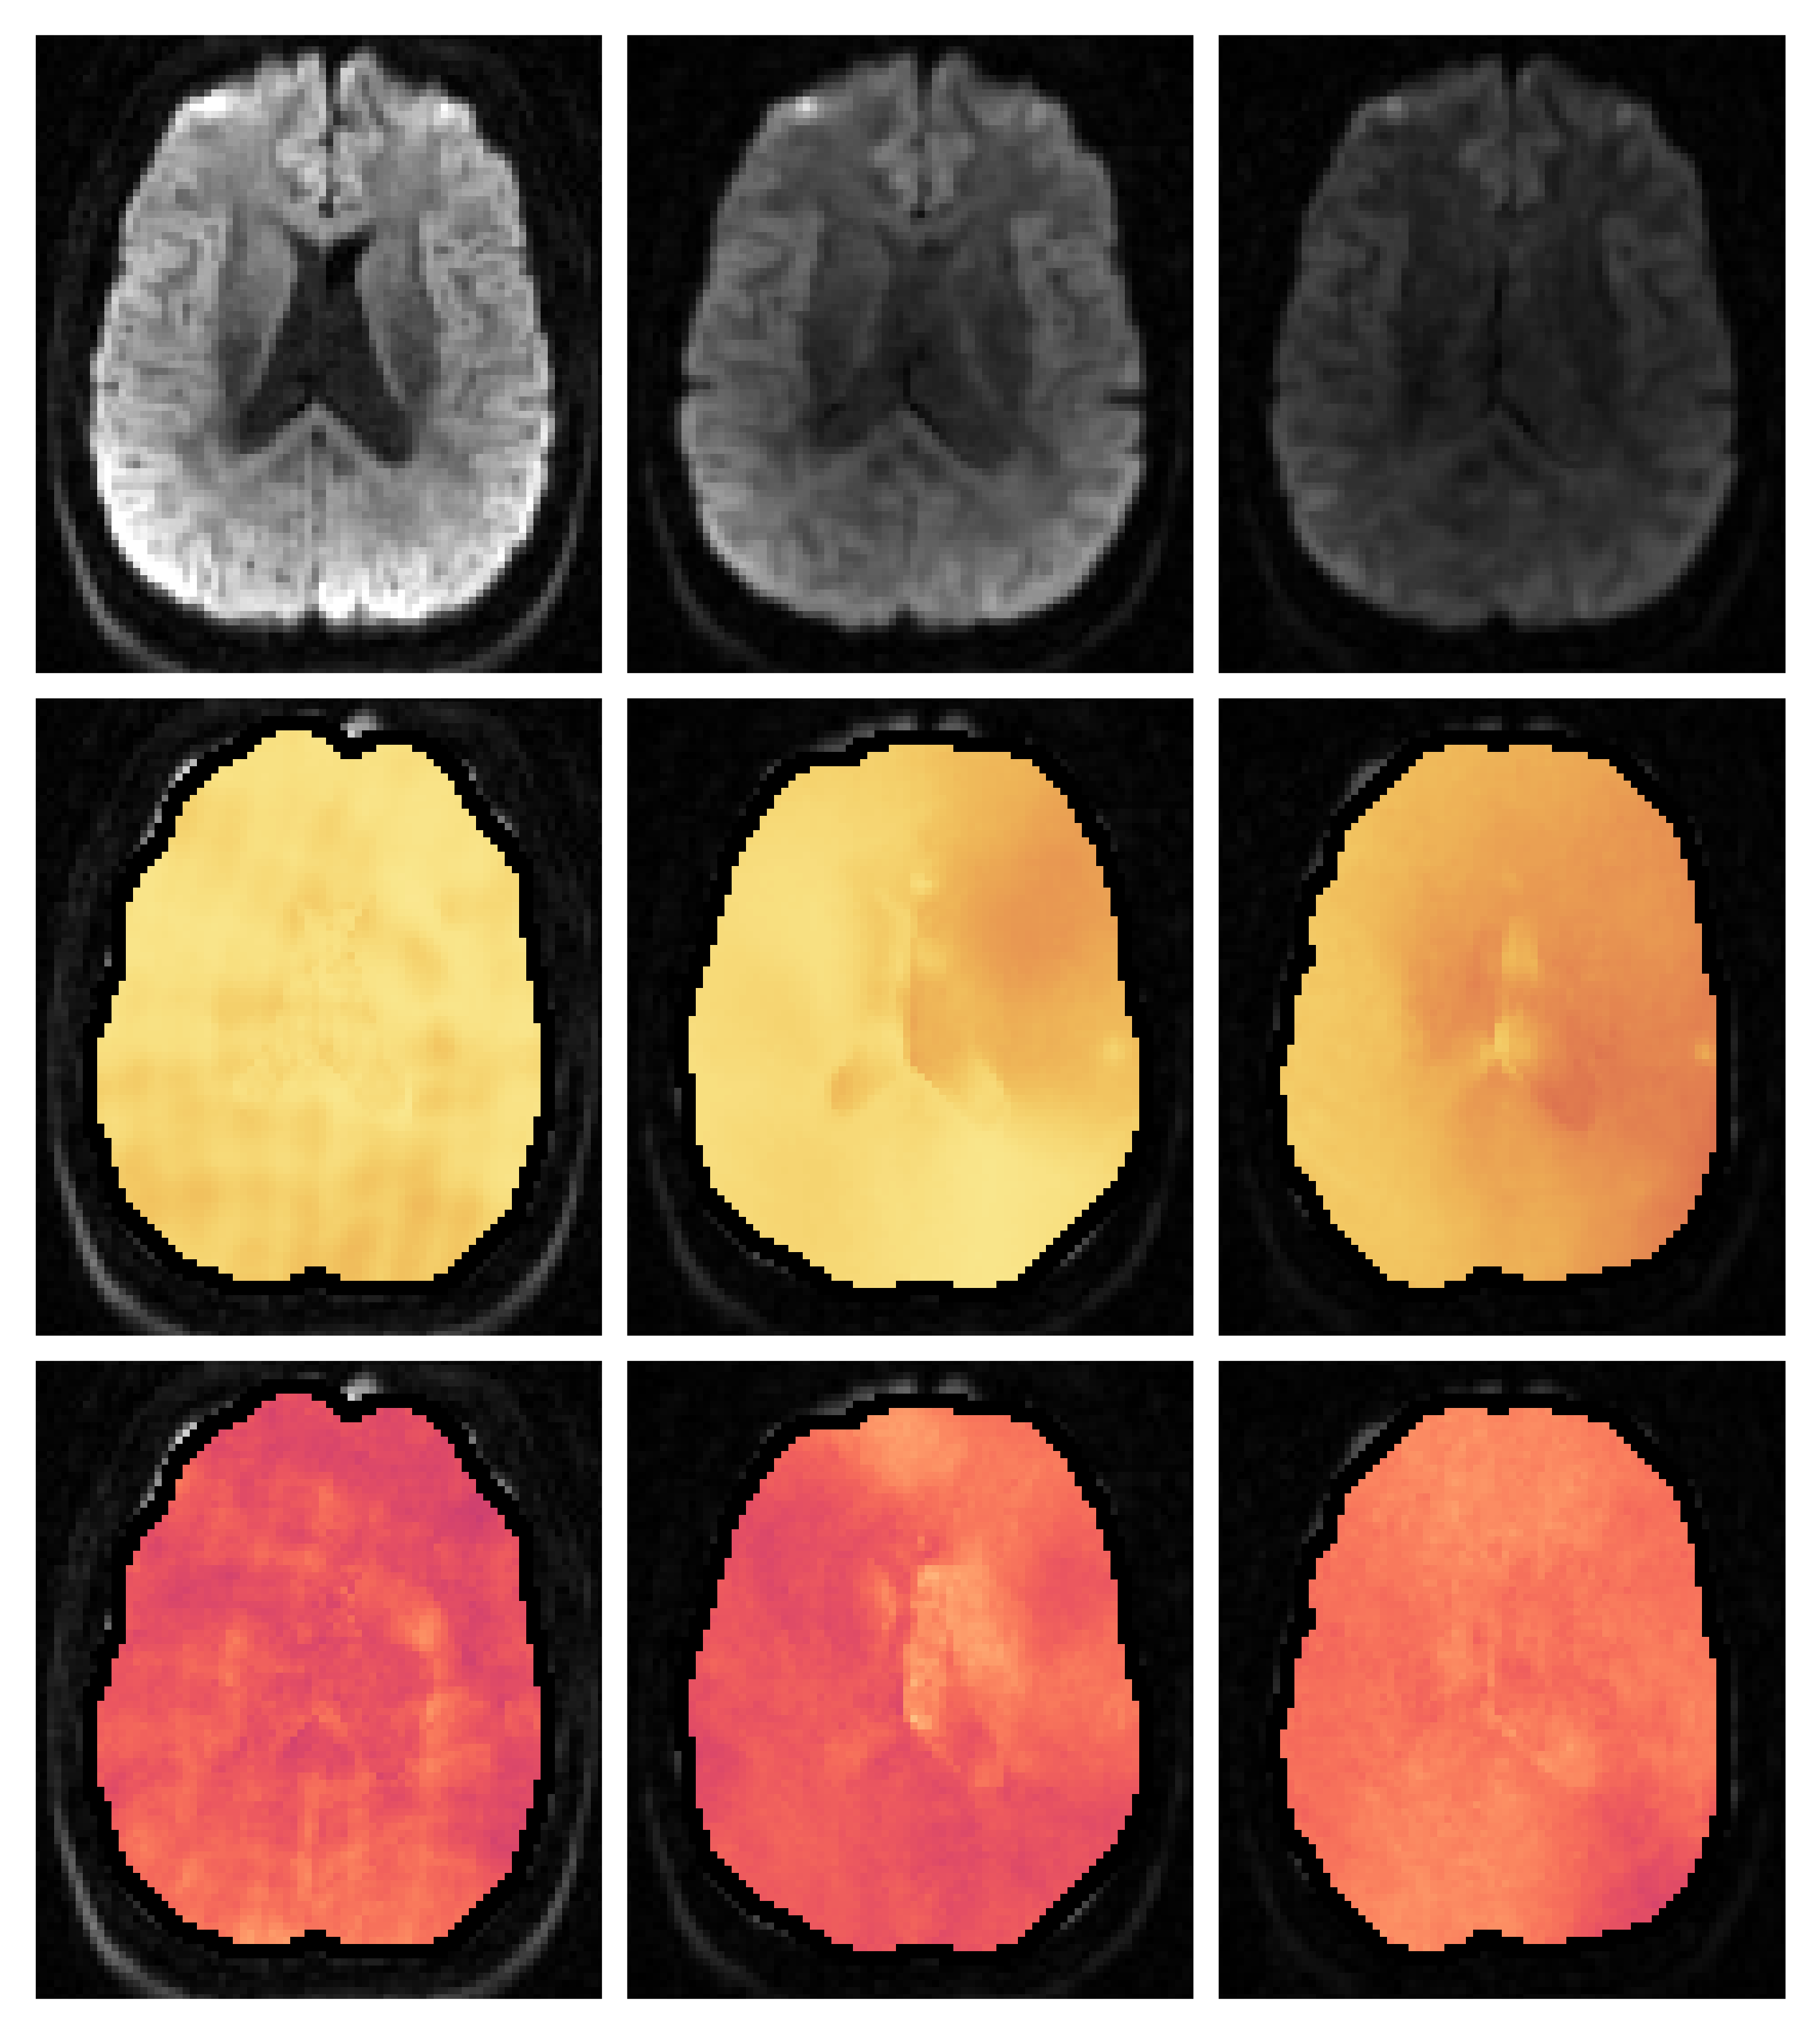

In [ ]:
vv = 6
sl = 3
diffusion= 3

volunteers=[1,2,3,4,5,7,8,9,10,11]
volunteer = str(volunteers[vv])
inpath = '/Volumes/RSLVA-RAID/ahannum/cDTI_Phase/Bootstrap/Phase/Data/V00' + volunteer 

savename = os.path.join(inpath,'M0_std_boostrap_analysis.npz')
med_m0 = np.load(savename)['avg']
ci_m0 = np.load(savename)['lb_ub'][1,:,:,:,:,] - np.load(savename)['lb_ub'][0,:,:,:,:,]

savename = os.path.join(inpath,'M1_std_boostrap_analysis.npz')
med_m1 = np.load(savename)['avg']
ci_m1 = np.load(savename)['lb_ub'][1,:,:,:,:,] - np.load(savename)['lb_ub'][0,:,:,:,:,]

savename = os.path.join(inpath,'M2_std_boostrap_analysis.npz')
med_m2 = np.load(savename)['avg']
ci_m2 = np.load(savename)['lb_ub'][1,:,:,:,:,] - np.load(savename)['lb_ub'][0,:,:,:,:,]



data,affine, voxsize = load_nifti(os.path.join(inpath, 'M0_registered_all.nii'), return_voxsize=True)
M0_mag = abs(data)
data,affine, voxsize = load_nifti(os.path.join(inpath, 'M1_registered_all.nii'), return_voxsize=True)
M1_mag = abs(data)
data,affine, voxsize = load_nifti(os.path.join(inpath, 'M2_registered_all.nii'), return_voxsize=True)
M2_mag = abs(data)




# Horizontal Fig 
td = vv

print('TD',td, 'Volunteer',vv,'sl',sl)
fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(7,8), dpi=500)

w1 = 25
w2 = 115
l1= 25
l2 = 105

color = cm.lajolla_r
rep = 0

for ii in range(3):
    axes[ii,0].imshow(abs(M0_mag)[w1:w2,l1:l2,sl,diffusion,rep],vmin = 0,vmax = 400,cmap = 'gray',interpolation = 'nearest')
    axes[ii,1].imshow(abs(M1_mag)[w1:w2,l1:l2,sl,diffusion,rep],vmin = 0,vmax = 400,cmap = 'gray',interpolation = 'nearest')
    axes[ii,2].imshow(abs(M2_mag)[w1:w2,l1:l2,sl,diffusion,rep],vmin = 0,vmax = 400,cmap = 'gray',interpolation = 'nearest')
    



######### STandard Deviation 
phs_m0 = (med_m0) #* M0_mask[:,:,:,diffusion,0,:]
phs_m1 = (med_m1) #* M1_mask[:,:,:,diffusion,0,:]
phs_m2 = (med_m2) #* M2_mask[:,:,:,diffusion,0,:] 
axes[1,0].imshow(phs_m0[w1:w2,l1:l2,sl,diffusion],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')
axes[1,1].imshow(phs_m1[w1:w2,l1:l2,sl,diffusion,],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')
im2=axes[1,2].imshow(phs_m2[w1:w2,l1:l2,sl,diffusion],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')


color = sns.color_palette("magma",as_cmap = True)
######### STandard Deviation 
phs_m0 = (ci_m0) #* M0_mask[:,:,:,diffusion,0,:]
phs_m1 = (ci_m1) #* M1_mask[:,:,:,diffusion,0,:]
phs_m2 = (ci_m2) #* M2_mask[:,:,:,diffusion,0,:] 
axes[2,0].imshow(phs_m0[w1:w2,l1:l2,sl,diffusion],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')
axes[2,1].imshow(phs_m1[w1:w2,l1:l2,sl,diffusion,],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')
im2=axes[2,2].imshow(phs_m2[w1:w2,l1:l2,sl,diffusion],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')

phse_m0 = np.where(np.isnan(phs_m0)==False)
for ii in range(1,3):
    axes[ii,0].imshow(get_edge((np.isnan(phs_m0)==False)[w1:w2,l1:l2,sl,diffusion]),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
    axes[ii,1].imshow(get_edge((np.isnan(phs_m1)==False)[w1:w2,l1:l2,sl,diffusion]),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
    axes[ii,2].imshow(get_edge((np.isnan(phs_m2)==False)[w1:w2,l1:l2,sl,diffusion]),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')



for m in range(3):
    for j in range(3):
        axes[m,j].get_xaxis().set_ticks([])
        axes[m,j].get_yaxis().set_ticks([])

plt.subplots_adjust(wspace=0.01, hspace=0.03)   
plt.show()

In [7]:
med_m0 = np.zeros((128,128,6,4,10))
med_m1 = np.zeros((128,128,6,4,10))
med_m2 = np.zeros((128,128,6,4,10))


ci_m0 = np.zeros((128,128,6,4,10))
ci_m1 = np.zeros((128,128,6,4,10))
ci_m2 = np.zeros((128,128,6,4,10))
for vv in range(10):

    volunteers=[1,2,3,4,5,7,8,9,10,11]
    volunteer = str(volunteers[vv])
    inpath = '/Volumes/RSLVA-RAID/ahannum/cDTI_Phase/Bootstrap/Phase/Data/V00' + volunteer 

    savename = os.path.join(inpath,'M0_std_boostrap_analysis.npz')
    med_m0[:,:,:,:,vv] = np.load(savename)['med']
    ci_m0[:,:,:,:,vv]  = np.load(savename)['lb_ub'][1,:,:,:,:,] - np.load(savename)['lb_ub'][0,:,:,:,:,]

    savename = os.path.join(inpath,'M1_std_boostrap_analysis.npz')
    med_m1[:,:,:,:,vv] = np.load(savename)['med']
    ci_m1[:,:,:,:,vv]  = np.load(savename)['lb_ub'][1,:,:,:,:,] - np.load(savename)['lb_ub'][0,:,:,:,:,]

    savename = os.path.join(inpath,'M2_std_boostrap_analysis.npz')
    med_m2[:,:,:,:,vv] = np.load(savename)['med']
    ci_m2[:,:,:,:,vv]  = np.load(savename)['lb_ub'][1,:,:,:,:,] - np.load(savename)['lb_ub'][0,:,:,:,:,]




In [8]:
import pandas as pd
med_m0_med = np.nanmean(med_m0,axis = (0,1))
med_m1_med = np.nanmean(med_m1,axis = (0,1))
med_m2_med = np.nanmean(med_m2,axis = (0,1))

med_stack = np.stack((med_m0_med,med_m1_med,med_m2_med),axis = -1)
print(med_stack.shape)

import pandas as pd
ci_m0_med = np.nanmean(ci_m0,axis = (0,1))
ci_m1_med = np.nanmean(ci_m1,axis = (0,1))
ci_m2_med = np.nanmean(ci_m2,axis = (0,1))

ci_stack = np.stack((ci_m0_med,ci_m1_med,ci_m2_med),axis = -1)
med_m0.shape

(6, 4, 10, 3)


(128, 128, 6, 4, 10)

In [9]:
atten_m0 = abs(np.sinc((med_m0) *2*2/2))
atten_m1 = abs(np.sinc((med_m1) *2*2/2))
atten_m2 = abs(np.sinc((med_m2) *2*2/2))


M0_avg = atten_m0
M1_avg = atten_m1
M2_avg = atten_m2

M0_atten_mean = np.nanmean(M0_avg, axis = (0,1))
M1_atten_mean = np.nanmean(M1_avg, axis = (0,1))
M2_atten_mean = np.nanmean(M2_avg, axis = (0,1))


atten_all = np.stack((M0_atten_mean,M1_atten_mean,M2_atten_mean),axis = -1)
atten_mean = np.nanmean(atten_all,axis = -2)

atten_all.shape


(6, 4, 10, 3)

0.12333361702597395

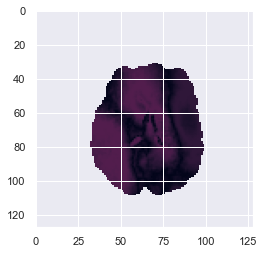

In [10]:
plt.imshow(atten_m2[:,:,3,-1,0],vmin = 0,vmax = 1)
np.nanmean(atten_m2[:,:,3,-1,0])

/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/arielhannu

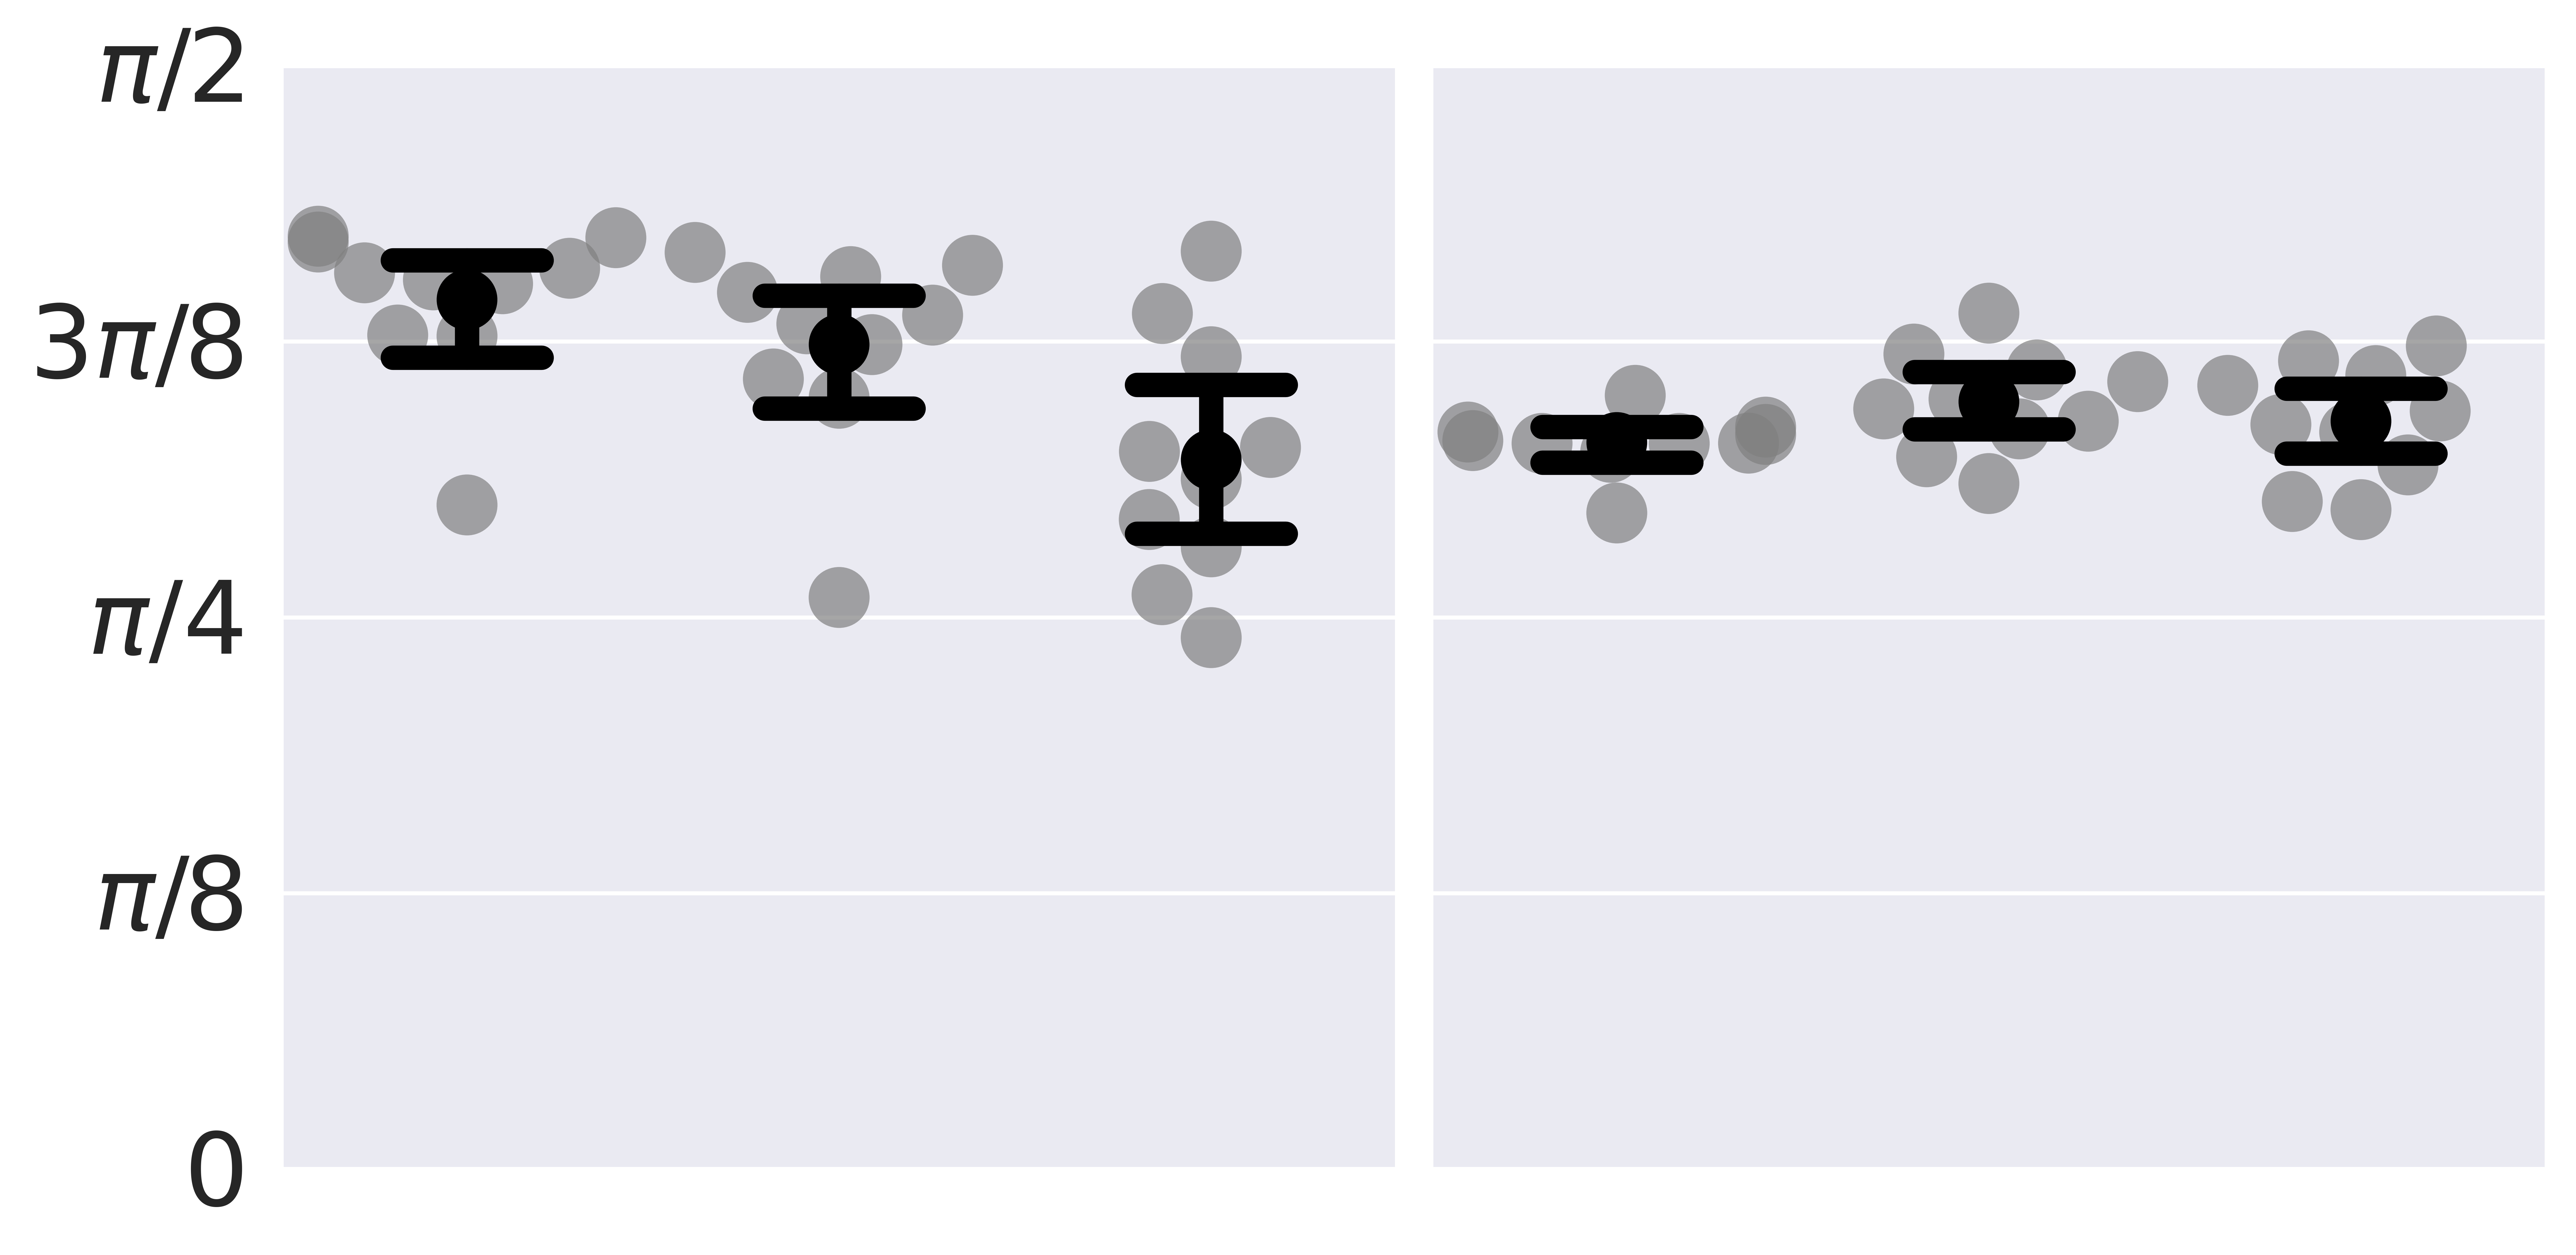

In [71]:

dd = -1
sl = 3

sns.set(style = 'darkgrid')

fig, axes = plt.subplots(1, 2, figsize=(10,5),sharex=True,sharey = True,dpi=1000)
count = 0
slices = [0,1,2]


for ii in range(2):
    axes[ii].set_xticks([0,1,2])
    axes[ii].set_xticklabels(['1','2','3'],size = 1,color='white')
    axes[ii].tick_params(axis='y', which='major', labelsize=15)
    axes[ii].tick_params(axis='x', which='major', labelsize=15)
    axes[ii].set_yticks([0,math.pi/8,math.pi/4,3*math.pi/8,math.pi/2])
    axes[ii].set_yticklabels(['$0$','$\pi/8$','$\pi/4$','$3\pi/8$','$\pi/2$'],size = 25,rotation = 0)
    axes[ii].set_ylim([0,math.pi/2])
    axes[ii].set_xlim([-0.2,2.2])
    axes[ii].set_xticks([0,1,2])
    axes[ii].set_xticklabels([0,1,2],size = 1,color = 'white',rotation = 0)
            

data = pd.DataFrame(med_stack[sl,dd,:,:])
sns.swarmplot(data=data,color = 'gray',
    size = 15,zorder = 1,edgecolor='gray', ax = axes[0],alpha = 0.7)


sns.pointplot(
    data=data,color = 'black',errwidth=6,scale = 1.7, errorbar=("se",np.nanstd(data,0)),
    capsize=.4, join=False, orient ='v',ax=axes[0],zorder = 2,
)


data = pd.DataFrame(ci_stack[sl,dd,:,:])
sns.swarmplot(data=data,color = 'gray',ax = axes[1],
    size = 15,zorder = 1,edgecolor='gray',alpha = 0.7)


sns.pointplot(
    data=data,color = 'black',errwidth=6,scale = 1.7,errorbar=("se",np.nanstd(data,0)),
    capsize=.4, join=False, orient ='v',ax=axes[1],zorder = 2,
)

plt.subplots_adjust(wspace=0.03, hspace=0.03)   
plt.show()



In [72]:

dd = 1
sl = 2



fig, axes = plt.subplots(3, 2, figsize=(10,15),sharex=True,sharey = True,dpi=1000)
count = 0
slices= [4,2,1]


for dd in range(3,4):
    for sl in range(3):
        for ii in range(2):
            axes[sl,ii].set_xticks([0,1,2])
            axes[sl,ii].set_xticklabels(['1','2','3'],size = 1,color='white')
            axes[sl,ii].tick_params(axis='y', which='major', labelsize=35)
            axes[sl,ii].tick_params(axis='x', which='major', labelsize=35)
            axes[sl,ii].set_yticks([0,math.pi/8,math.pi/4,3*math.pi/8,math.pi/2])
            axes[sl,ii].set_yticklabels(['$0$','$\pi/8$','$\pi/4$','$3\pi/8$','$\pi/2$'],size = 25,rotation = 0)
            axes[sl,ii].set_ylim([0,math.pi/2])
            axes[sl,ii].set_xlim([-0.2,2.2])
            axes[sl,ii].set_xticks([0,1,2])
            axes[sl,ii].set_xticklabels([0,1,2],size = 1,color = 'white',rotation = 0)
                
        data = pd.DataFrame(med_stack[slices[sl],dd,:,:])
        sns.swarmplot(data=data,color = 'gray',
            size = 15,zorder = 1,edgecolor='gray', ax = axes[sl,0],alpha = 0.7)

        sns.pointplot(
            data=data,color = 'black',errwidth=6,scale = 1.7, errorbar=("se",np.nanstd(data,0)),
            capsize=.4, join=False, orient ='v',ax=axes[sl,0],zorder = 2
        )

        data = pd.DataFrame(ci_stack[slices[sl],dd,:,:])
        sns.swarmplot(data=data,color = 'gray',
            size = 15,zorder = 1,edgecolor='gray', ax = axes[sl,1],alpha = 0.7)
        
        print(data.shape)
        sns.pointplot(
            data=data,color = 'black',errwidth=6,scale = 1.7, errorbar=("se",np.nanstd(data,0)),
            capsize=.4, join=False, orient ='v',ax=axes[sl,1],zorder =2,
        )


plt.subplots_adjust(wspace=0.05, hspace=0.1)  
plt.show()





/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/arielhannum/opt

(10, 3)
(10, 3)


/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/arielhannu

(10, 3)


In [73]:

dd = 1
sl = 3



fig, axes = plt.subplots(3, 2, figsize=(10,15),sharex=True,sharey = True,dpi=1000)
count = 0
slices= [5,4,3,2,1,0]


for dd in range(3):
    for sl in range(3,4):
        for ii in range(2):
            axes[dd,ii].set_xticks([0,1,2])
            axes[dd,ii].set_xticklabels(['1','2','3'],size = 1,color='white')
            axes[dd,ii].tick_params(axis='y', which='major', labelsize=35)
            axes[dd,ii].tick_params(axis='x', which='major', labelsize=35)
            axes[dd,ii].set_yticks([0,math.pi/8,math.pi/4,3*math.pi/8,math.pi/2])
            axes[dd,ii].set_yticklabels(['$0$','$\pi/8$','$\pi/4$','$3\pi/8$','$\pi/2$'],size = 25,rotation = 0)
            axes[dd,ii].set_ylim([0,math.pi/2])
            axes[dd,ii].set_xlim([-0.2,2.2])
            axes[dd,ii].set_xticks([0,1,2])
            axes[dd,ii].set_xticklabels([0,1,2],size = 1,color = 'white',rotation = 0)

        print(med_stack[sl,dd,:,:])
        data = pd.DataFrame(med_stack[sl,dd,:,:])
        sns.stripplot(data=data,color = 'gray',
            size = 15,zorder = 1,edgecolor='gray', ax = axes[dd,0],alpha = 0.7)


        sns.pointplot(
            data=data,color = 'black',errwidth=6,scale = 1.7, errorbar=("se",np.nanstd(data,0)),
            capsize=.4, join=False, orient ='v',ax=axes[dd,0],zorder = 2,
        )


        data = pd.DataFrame(ci_stack[sl,dd,:,:])
        sns.stripplot(data=data,color = 'gray',
            size = 15,zorder = 1,edgecolor='gray', ax = axes[dd,1],alpha = 0.7)


        sns.pointplot(
            data=data,color = 'black',errwidth=6,scale = 1.7, errorbar=("se",np.nanstd(data,0)),
            capsize=.4, join=False, orient ='v',ax=axes[dd,1],zorder = 2,
        )


plt.subplots_adjust(wspace=0.05, hspace=0.1)  
plt.show()





[[0.0386337  0.03837057 0.06220696]
 [0.02966905 0.04599253 0.05536447]
 [0.02532464 0.04577114 0.05986807]
 [0.04341681 0.0407778  0.0544997 ]
 [0.04910485 0.06962032 0.10836987]
 [0.03023134 0.04069984 0.05786542]
 [0.0924304  0.0512788  0.06701671]
 [0.03163251 0.04416048 0.05907875]
 [0.0350722  0.04109883 0.06014133]
 [0.02501899 0.0323019  0.05419443]]
[[0.85147908 0.51279691 0.68066707]
 [0.62599263 0.73362438 0.70836184]
 [0.73320208 0.84510825 0.91394429]
 [0.85912176 0.94424382 0.96509761]
 [1.17184987 0.86030004 0.67590567]
 [0.66368372 0.57400468 0.55988591]
 [0.80888342 0.73817777 0.71178749]
 [0.66473797 0.74683311 0.7636703 ]
 [0.71223507 0.7483858  0.8162676 ]
 [0.67980069 0.50153408 0.57002015]]


/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/ariel

[[0.66579037 0.51851618 0.73375533]
 [0.68351069 0.61397296 0.53497615]
 [0.8280886  0.85416223 0.90141926]
 [0.68984417 0.68712313 0.76474876]
 [0.6088101  0.65943556 0.63680519]
 [0.71767575 0.61839517 0.59535439]
 [0.90717699 0.69849435 0.79908955]
 [0.5896904  0.37773615 0.53296785]
 [0.61473566 0.65935465 0.50789583]
 [0.53632447 0.41274159 0.38312634]]


/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


In [ ]:
[4,2,1]

[4, 2, 1]

/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/multitest.py:177: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:194: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:199: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


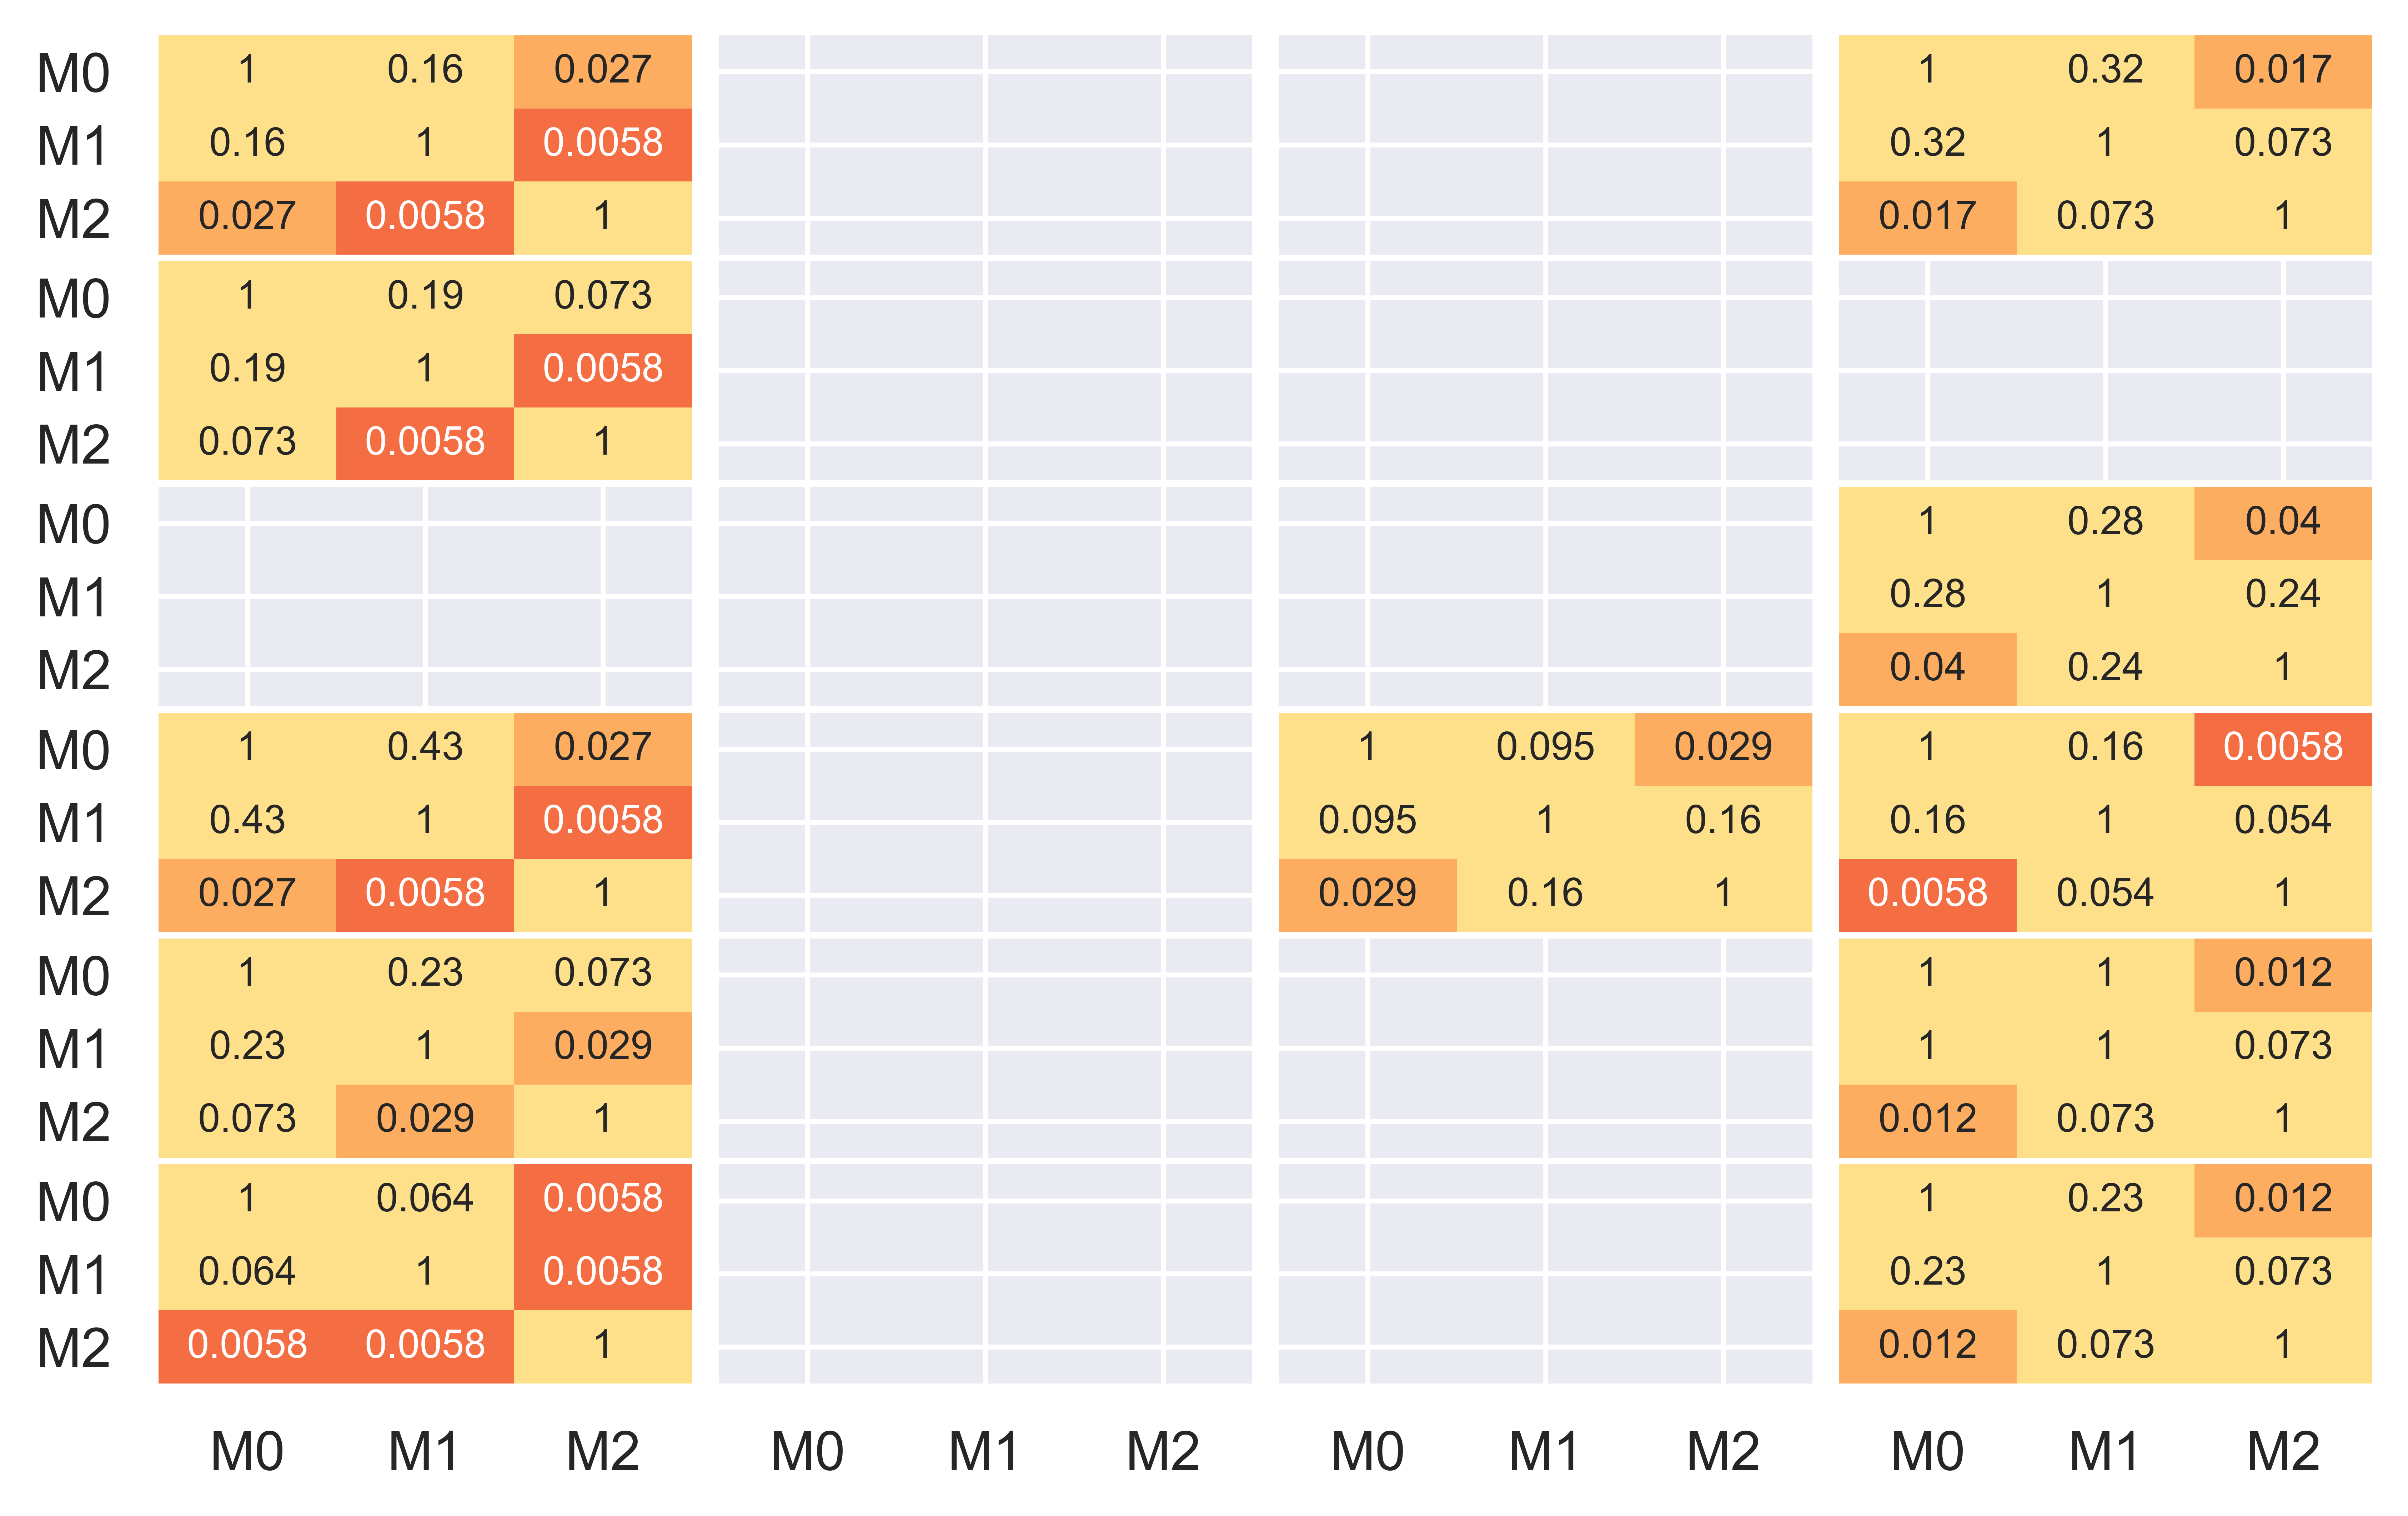

In [49]:
# Looking at Confidence intervals of the phase differences seeing if there is significant decrease with increasing motion compensation
import scikit_posthocs as sp
from scipy import stats
alpha= 0.05





hypothesis = np.zeros((6,4,3,3))
hypothesis[:] = np.nan

slices = [5,4,3,2,1,0]
for sl in range(6):
    for dd in range(4):
        group1 = med_stack[slices[sl],dd,:,0]
        group2 = med_stack[slices[sl],dd,:,1]
        group3 = med_stack[slices[sl],dd,:,2]

        # Test for normality
        tests = [stats.shapiro(group1)[1] <alpha,stats.shapiro(group2)[1] <alpha, stats.shapiro(group3)[1] <alpha]
        if np.sum(tests) > 0:
            normal = 0
        else:
            normal = 1
        if normal ==0:
            result = stats.friedmanchisquare(group1, group2, group3)
            if result[1] < alpha:
                test = sp.posthoc_wilcoxon([group1,group2,group3],p_adjust = 'holm-sidak')
                hypothesis[sl,dd,:,:] = test
            else:
                hypothesis[sl,dd,:,:] = np.nan

        elif normal ==1:
            result = stats.f_oneway(group1, group2, group3)
            if result[1] < alpha:
                test = sp.posthoc_ttest([group1,group2,group3],p_adjust = 'holm-sidak')
                hypothesis[sl,dd,:,:] = test 
            else:
                hypothesis[sl,dd,:,:] = np.nan



from matplotlib.colors import BoundaryNorm, ListedColormap
import seaborn as sns
import numpy as np

my_colors = [sns.color_palette("Spectral",9)[0], sns.color_palette("Spectral",9)[1], sns.color_palette("Spectral",9)[2], 
            sns.color_palette("Spectral",9)[3]]
my_cmap = ListedColormap(my_colors)
bounds = [0, 0.001, 0.01, 0.05,1]
my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))

fig, axes = plt.subplots(6, 4, figsize=(8,5),sharex=True,sharey = True,dpi=1000)
count = 2
for sl in range(6):
    for dirs in range(4):
        ax=sns.heatmap(hypothesis[count,dirs,:,:],ax = axes[sl,dirs], annot = True, xticklabels=['M0','M1','M2'],
                    yticklabels=['M0','M1','M2'],norm=my_norm,cmap = my_cmap,cbar = False,annot_kws={"fontsize":8})
        #c_bar = ax.collections[0].colorbar
        #c_bar.set_ticks([(0 + 0.001)/2,(0.001+0.01)/2,(0.01+0.05)/2,(0.05+1)/2])
        #c_bar.set_ticklabels(['p<0.001','p<0.01','p<0.05','n.s.'])  
        #c_bar.set_ticklabels(['p<0.001','p<0.01','p<0.05','n.s.'])  


    count = count -1

plt.subplots_adjust(wspace=0.05, hspace=0.03)




In [55]:
sys.path.append('/Users/arielhannum/Documents/GitHub/dwi_phase/Interactive_Figs')
from helper_phase_utils_heart import *
# Get the summative count for all the data:
m0_v_m1 = np.zeros((4,6))
m0_v_m2 = np.zeros((4,6))
m1_v_m2 = np.zeros((4,6))

mean_combo = med_stack

# Iterate through slice, diffusion, td
for diffusion in range(4):
    for slice in range(6):
        group1 = np.mean(mean_combo[slice,diffusion,:,0])
        group2 = np.mean(mean_combo[slice,diffusion,:,1])
        group3 = np.mean(mean_combo[slice,diffusion,:,2])
        hypothesis = compute_statistics_motionComp(mean_combo[slice,diffusion,:,:],0.05)
        if np.array(hypothesis)[0,1] < 0.05 and group2<group1:
            m0_v_m1[diffusion,slice] = 1
        if np.array(hypothesis)[0,2] < 0.05 and group3<group1:
            m0_v_m2[diffusion,slice] = 1
        if np.array(hypothesis)[1,2] < 0.05 and group3<group2:
            m1_v_m2[diffusion,slice] = 1

# Get the summative count for all the data:
print('Per Diffusion where std temporal phase gradient decreases with motion compensation')
for diffusion in range(4):
    total = 6
    print('Diffusion: ',diffusion,' m0_v_m1: ',np.sum(m0_v_m1[diffusion,:])/total*100,'% \t',\
        ' m0_v_m2: ',np.sum(m0_v_m2[diffusion,:])/total*100,'%\t',' m1_v_m2: ',np.sum(m1_v_m2[diffusion,:])/total*100,'%\t')


# Get the summative count for all the data:
print('Per Diffusion Where motion compensation is reducing temporal phase gradient mean')
m0m1 = 0
m0m2 = 0
m1m2=0
hypothesis = compute_statistics_motionComp(mean_combo[slice,diffusion,:,:],0.05)
if np.array(hypothesis)[0,1] < 0.05:
    m0m1+=1
if np.array(hypothesis)[0,2] < 0.05:
    m0m2+=1
if np.array(hypothesis)[1,2] < 0.05:
    m1m2+=1

print(m0m1*100,m0m2*100,m1m2*100)



print('\n\n')
##### Where the mean temporal phase increases with motion compensation
m0_v_m1 = np.zeros((4,6))
m0_v_m2 = np.zeros((4,6))
m1_v_m2 = np.zeros((4,6))
# Iterate through slice, diffusion, td
for diffusion in range(4):
    for slice in range(6):
        group1 = np.mean(mean_combo[slice,diffusion,:,0])
        group2 = np.mean(mean_combo[slice,diffusion,:,1])
        group3 = np.mean(mean_combo[slice,diffusion,:,2])
        hypothesis = compute_statistics_motionComp(mean_combo[slice,diffusion,:,:],0.05)
        if np.array(hypothesis)[0,1] < 0.05 and group2>group1:
            m0_v_m1[diffusion,slice] = 1
        if np.array(hypothesis)[0,2] < 0.05 and group3>group1:
            m0_v_m2[diffusion,slice] = 1
        if np.array(hypothesis)[1,2] < 0.05 and group3>group2:
            m1_v_m2[diffusion,slice] = 1

# Get the summative count for all the data:
print('Per Diffusion Where motion compensation increases temporal phase gradient mean')
for diffusion in range(4):
    total = 6
    print('Diffusion: ',diffusion,' m0_v_m1: ',np.sum(m0_v_m1[diffusion,:])/total*100,'% \t',\
        ' m0_v_m2: ',np.sum(m0_v_m2[diffusion,:])/total*100,'%\t',' m1_v_m2: ',np.sum(m1_v_m2[diffusion,:])/total*100,'%\t')




     

Per Diffusion where std temporal phase gradient decreases with motion compensation
Diffusion:  0  m0_v_m1:  0.0 % 	  m0_v_m2:  0.0 %	  m1_v_m2:  0.0 %	
Diffusion:  1  m0_v_m1:  0.0 % 	  m0_v_m2:  0.0 %	  m1_v_m2:  0.0 %	
Diffusion:  2  m0_v_m1:  0.0 % 	  m0_v_m2:  16.666666666666664 %	  m1_v_m2:  0.0 %	
Diffusion:  3  m0_v_m1:  0.0 % 	  m0_v_m2:  83.33333333333334 %	  m1_v_m2:  0.0 %	
Per Diffusion Where motion compensation is reducing temporal phase gradient mean
0 100 0



Per Diffusion Where motion compensation increases temporal phase gradient mean
Diffusion:  0  m0_v_m1:  0.0 % 	  m0_v_m2:  50.0 %	  m1_v_m2:  83.33333333333334 %	
Diffusion:  1  m0_v_m1:  0.0 % 	  m0_v_m2:  0.0 %	  m1_v_m2:  0.0 %	
Diffusion:  2  m0_v_m1:  0.0 % 	  m0_v_m2:  0.0 %	  m1_v_m2:  0.0 %	
Diffusion:  3  m0_v_m1:  0.0 % 	  m0_v_m2:  0.0 %	  m1_v_m2:  0.0 %	


/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/multitest.py:177: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/multitest.py:177: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))


In [56]:
print('---Mean---')
for ii in range(4):
    print('Diffusion:', ii, ':', np.round(np.nanmean(mean_combo,axis = (0,2)),2)[ii,:])
print('---Std---')
for ii in range(4):
    print('Diffusion:', ii, ':', np.round(np.nanstd(mean_combo,axis = (0,2)),2)[ii,:])

---Mean---
Diffusion: 0 : [0.07 0.08 0.1 ]
Diffusion: 1 : [0.83 0.81 0.82]
Diffusion: 2 : [0.75 0.65 0.65]
Diffusion: 3 : [1.22 1.17 1.02]
---Std---
Diffusion: 0 : [0.08 0.08 0.1 ]
Diffusion: 1 : [0.22 0.18 0.17]
Diffusion: 2 : [0.18 0.17 0.17]
Diffusion: 3 : [0.14 0.16 0.16]


In [59]:
np.nanmean(med_stack,axis = (0,2)), np.nanstd(med_stack,axis = (0,2)), 

(array([[0.0731085 , 0.07895428, 0.10055489],
        [0.83401193, 0.81119718, 0.82004011],
        [0.7455579 , 0.65431143, 0.64644774],
        [1.22481783, 1.1682287 , 1.01634125]]),
 array([[0.07507544, 0.08134246, 0.0951828 ],
        [0.22486122, 0.18396087, 0.16909428],
        [0.17877855, 0.17386837, 0.16510128],
        [0.14105815, 0.15635451, 0.15655862]]))

/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:194: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:199: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


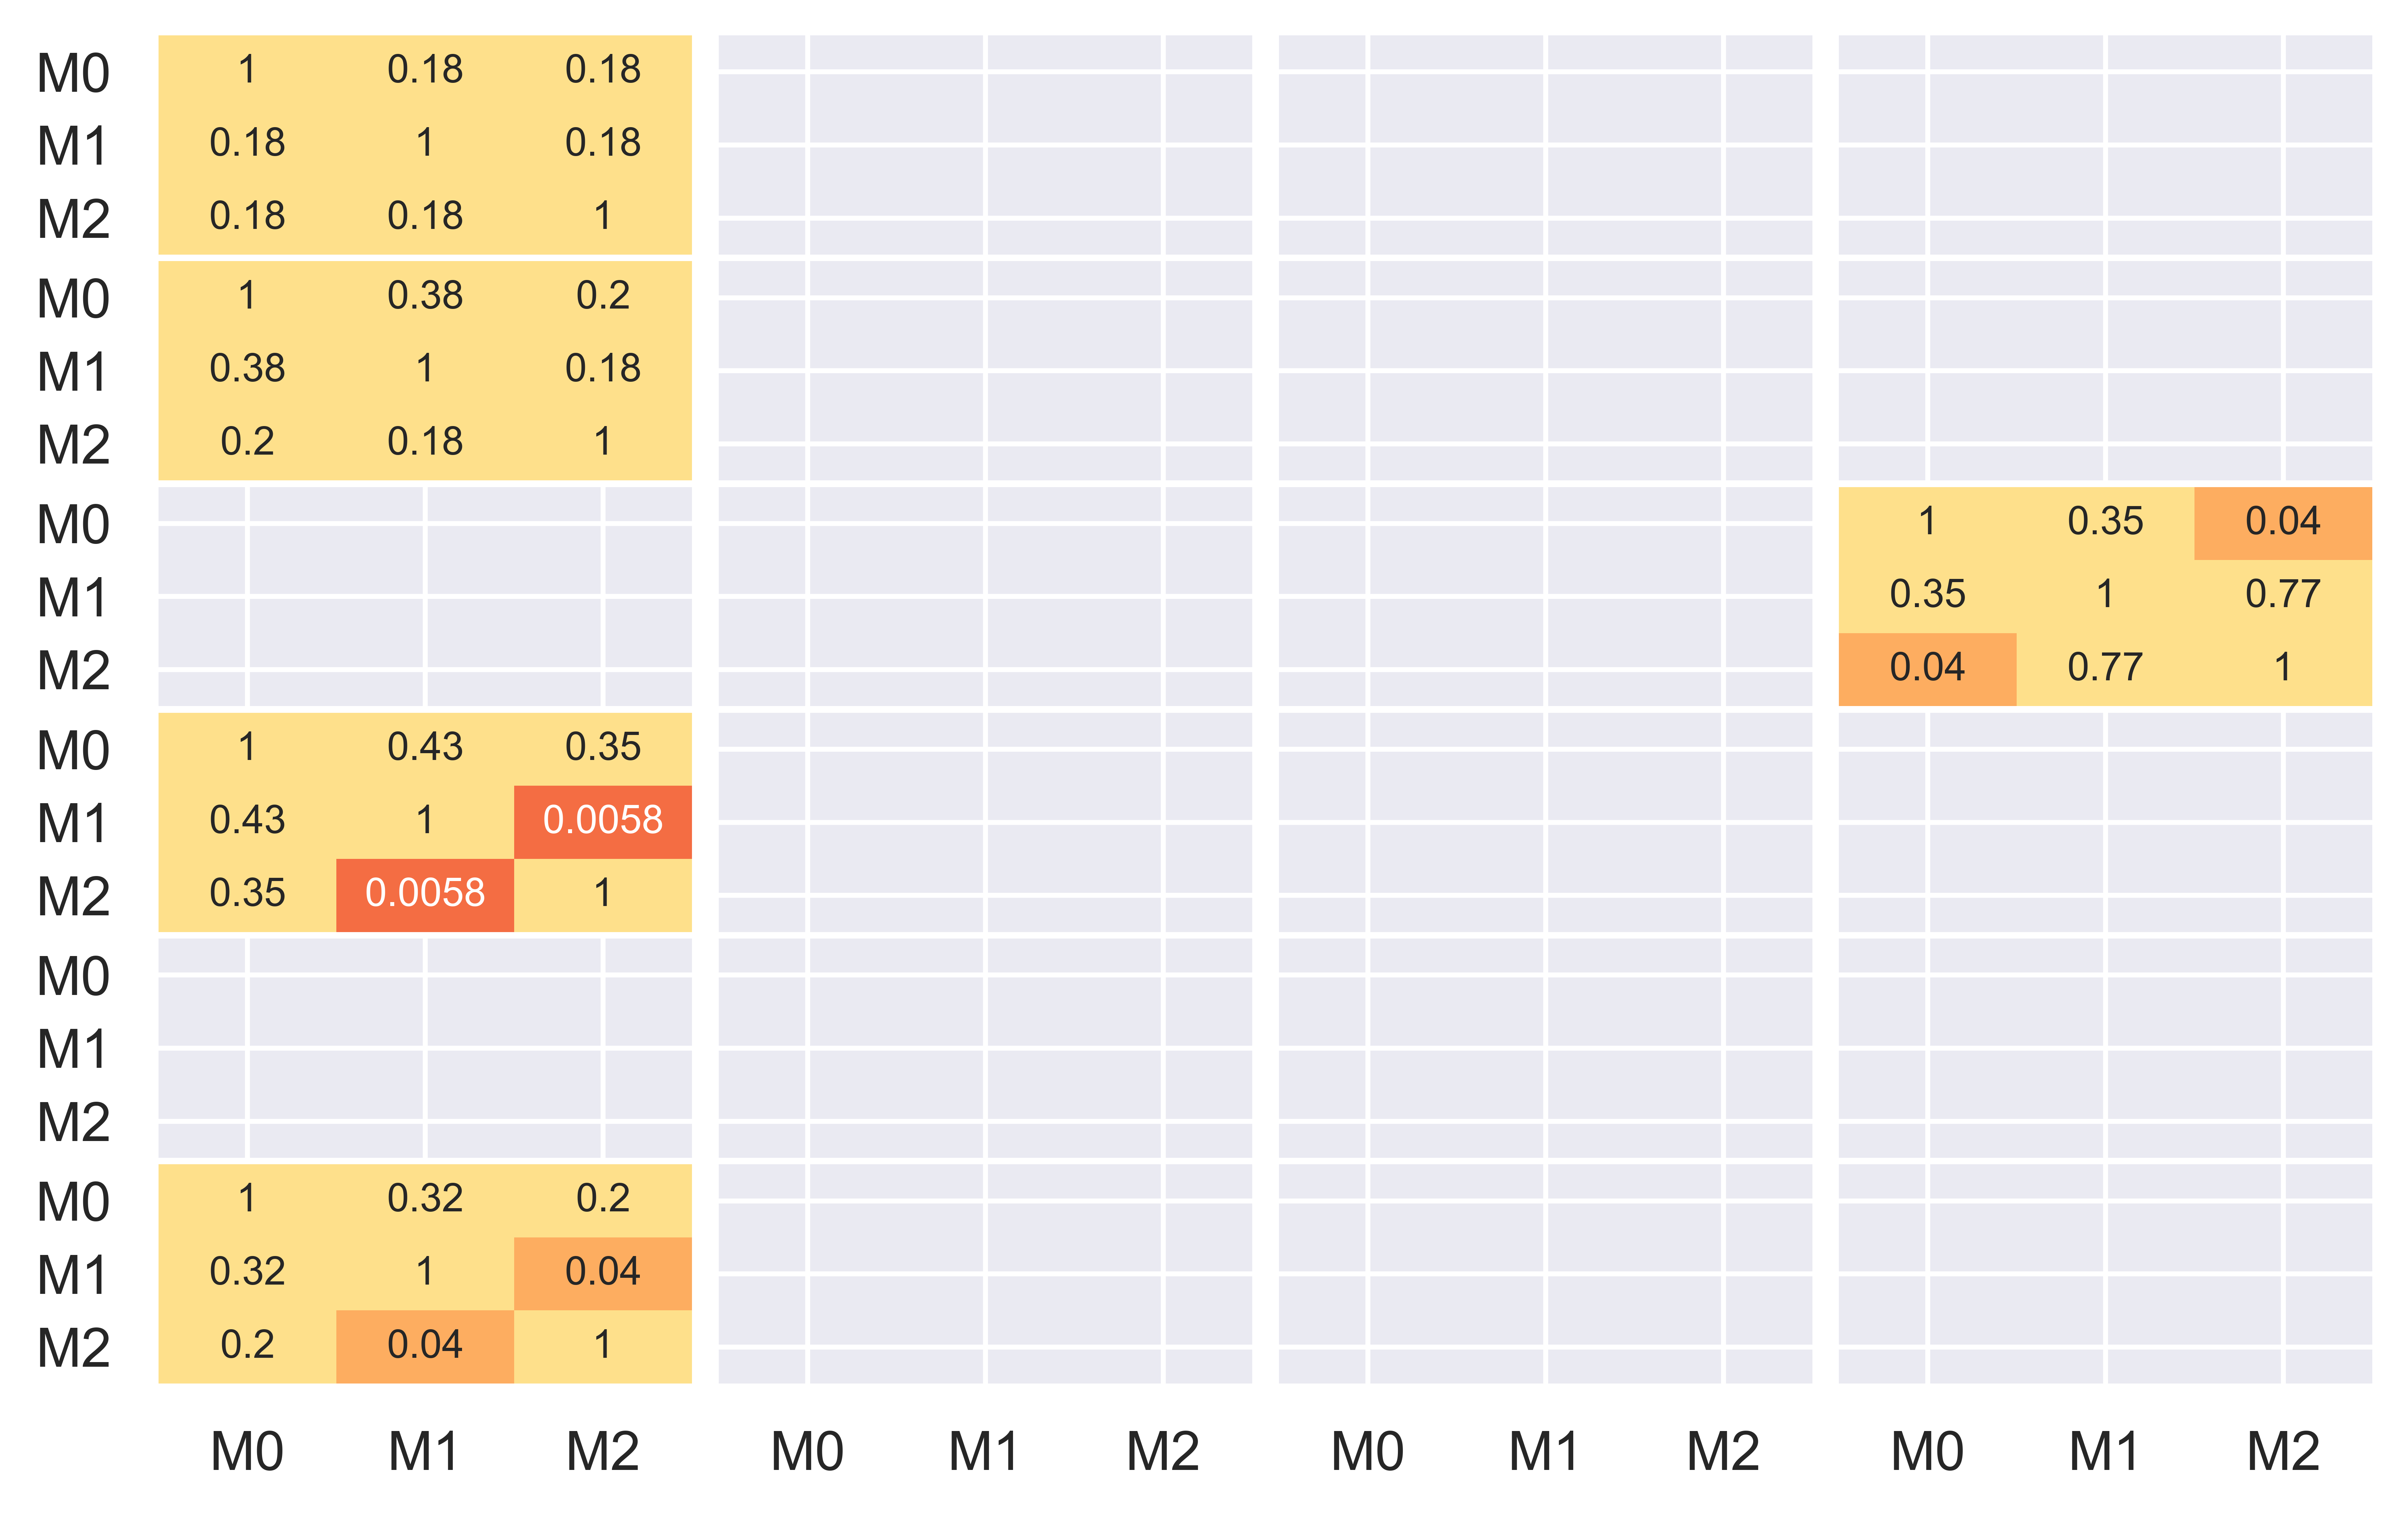

In [53]:
# Looking at Confidence intervals of the phase differences seeing if there is significant decrease with increasing motion compensation
import scikit_posthocs as sp
from scipy import stats
alpha= 0.05

hypothesis = np.zeros((6,4,3,3))
hypothesis[:] = np.nan

slices = [5,4,3,2,1,0]
for sl in range(6):
    for dd in range(4):
        group1 = ci_stack[slices[sl],dd,:,0]
        group2 = ci_stack[slices[sl],dd,:,1]
        group3 = ci_stack[slices[sl],dd,:,2]

        # Test for normality
        tests = [stats.shapiro(group1)[1] <alpha,stats.shapiro(group2)[1] <alpha, stats.shapiro(group3)[1] <alpha]
        if np.sum(tests) > 0:
            normal = 0
        else:
            normal = 1

            
        if normal ==0:
            result = stats.friedmanchisquare(group1, group2, group3)
            if result[1] < alpha:
                test = sp.posthoc_wilcoxon([group1,group2,group3],p_adjust = 'holm-sidak')
                hypothesis[sl,dd,:,:] = test
            else:
                hypothesis[sl,dd,:,:] = np.nan

        elif normal ==1:
            result = stats.f_oneway(group1, group2, group3)
            if result[1] < alpha:
                test = sp.posthoc_ttest([group1,group2,group3],p_adjust = 'holm-sidak')
                hypothesis[sl,dd,:,:] = test 
            else:
                hypothesis[sl,dd,:,:] = np.nan



from matplotlib.colors import BoundaryNorm, ListedColormap
import seaborn as sns
import numpy as np

my_colors = [sns.color_palette("Spectral",9)[0], sns.color_palette("Spectral",9)[1], sns.color_palette("Spectral",9)[2], 
            sns.color_palette("Spectral",9)[3]]
my_cmap = ListedColormap(my_colors)
bounds = [0, 0.001, 0.01, 0.05,1]
my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))

fig, axes = plt.subplots(6, 4, figsize=(8,5),sharex=True,sharey = True,dpi=1000)
count = 2
for sl in range(6):
    for dirs in range(4):
        ax=sns.heatmap(hypothesis[count,dirs,:,:],ax = axes[sl,dirs], annot = True, xticklabels=['M0','M1','M2'],
                    yticklabels=['M0','M1','M2'],norm=my_norm,cmap = my_cmap,cbar = False,annot_kws={"fontsize":8})
        #c_bar = ax.collections[0].colorbar
        #c_bar.set_ticks([(0 + 0.001)/2,(0.001+0.01)/2,(0.01+0.05)/2,(0.05+1)/2])
        #c_bar.set_ticklabels(['p<0.001','p<0.01','p<0.05','n.s.'])  
        #c_bar.set_ticklabels(['p<0.001','p<0.01','p<0.05','n.s.'])  


    count = count -1

plt.subplots_adjust(wspace=0.05, hspace=0.03)




In [54]:
sys.path.append('/Users/arielhannum/Documents/GitHub/dwi_phase/Interactive_Figs')
from helper_phase_utils_heart import *
# Get the summative count for all the data:
m0_v_m1 = np.zeros((4,6))
m0_v_m2 = np.zeros((4,6))
m1_v_m2 = np.zeros((4,6))

mean_combo = ci_stack

# Iterate through slice, diffusion, td
for diffusion in range(4):
    for slice in range(6):
        group1 = np.mean(mean_combo[slice,diffusion,:,0])
        group2 = np.mean(mean_combo[slice,diffusion,:,1])
        group3 = np.mean(mean_combo[slice,diffusion,:,2])
        hypothesis = compute_statistics_motionComp(mean_combo[slice,diffusion,:,:],0.05)
        if np.array(hypothesis)[0,1] < 0.05 and group2<group1:
            m0_v_m1[diffusion,slice] = 1
        if np.array(hypothesis)[0,2] < 0.05 and group3<group1:
            m0_v_m2[diffusion,slice] = 1
        if np.array(hypothesis)[1,2] < 0.05 and group3<group2:
            m1_v_m2[diffusion,slice] = 1

# Get the summative count for all the data:
print('Per Diffusion where std temporal phase gradient decreases with motion compensation')
for diffusion in range(4):
    total = 6
    print('Diffusion: ',diffusion,' m0_v_m1: ',np.sum(m0_v_m1[diffusion,:])/total*100,'% \t',\
        ' m0_v_m2: ',np.sum(m0_v_m2[diffusion,:])/total*100,'%\t',' m1_v_m2: ',np.sum(m1_v_m2[diffusion,:])/total*100,'%\t')


# Get the summative count for all the data:
print('Per Diffusion Where motion compensation is reducing temporal phase gradient mean')
m0m1 = 0
m0m2 = 0
m1m2=0
hypothesis = compute_statistics_motionComp(mean_combo[slice,diffusion,:,:],0.05)
if np.array(hypothesis)[0,1] < 0.05:
    m0m1+=1
if np.array(hypothesis)[0,2] < 0.05:
    m0m2+=1
if np.array(hypothesis)[1,2] < 0.05:
    m1m2+=1

print(m0m1*100,m0m2*100,m1m2*100)



print('\n\n')
##### Where the mean temporal phase increases with motion compensation
m0_v_m1 = np.zeros((4,6))
m0_v_m2 = np.zeros((4,6))
m1_v_m2 = np.zeros((4,6))
# Iterate through slice, diffusion, td
for diffusion in range(4):
    for slice in range(6):
        group1 = np.mean(mean_combo[slice,diffusion,:,0])
        group2 = np.mean(mean_combo[slice,diffusion,:,1])
        group3 = np.mean(mean_combo[slice,diffusion,:,2])
        hypothesis = compute_statistics_motionComp(mean_combo[slice,diffusion,:,:],0.05)
        if np.array(hypothesis)[0,1] < 0.05 and group2>group1:
            m0_v_m1[diffusion,slice] = 1
        if np.array(hypothesis)[0,2] < 0.05 and group3>group1:
            m0_v_m2[diffusion,slice] = 1
        if np.array(hypothesis)[1,2] < 0.05 and group3>group2:
            m1_v_m2[diffusion,slice] = 1

# Get the summative count for all the data:
print('Per Diffusion Where motion compensation increases temporal phase gradient mean')
for diffusion in range(4):
    total = 6
    print('Diffusion: ',diffusion,' m0_v_m1: ',np.sum(m0_v_m1[diffusion,:])/total*100,'% \t',\
        ' m0_v_m2: ',np.sum(m0_v_m2[diffusion,:])/total*100,'%\t',' m1_v_m2: ',np.sum(m1_v_m2[diffusion,:])/total*100,'%\t')




     

Per Diffusion where std temporal phase gradient decreases with motion compensation
Diffusion:  0  m0_v_m1:  0.0 % 	  m0_v_m2:  0.0 %	  m1_v_m2:  0.0 %	
Diffusion:  1  m0_v_m1:  0.0 % 	  m0_v_m2:  0.0 %	  m1_v_m2:  0.0 %	
Diffusion:  2  m0_v_m1:  0.0 % 	  m0_v_m2:  0.0 %	  m1_v_m2:  0.0 %	
Diffusion:  3  m0_v_m1:  0.0 % 	  m0_v_m2:  0.0 %	  m1_v_m2:  0.0 %	
Per Diffusion Where motion compensation is reducing temporal phase gradient mean
0 100 0



Per Diffusion Where motion compensation increases temporal phase gradient mean
Diffusion:  0  m0_v_m1:  0.0 % 	  m0_v_m2:  0.0 %	  m1_v_m2:  33.33333333333333 %	
Diffusion:  1  m0_v_m1:  0.0 % 	  m0_v_m2:  0.0 %	  m1_v_m2:  0.0 %	
Diffusion:  2  m0_v_m1:  0.0 % 	  m0_v_m2:  0.0 %	  m1_v_m2:  0.0 %	
Diffusion:  3  m0_v_m1:  0.0 % 	  m0_v_m2:  16.666666666666664 %	  m1_v_m2:  0.0 %	


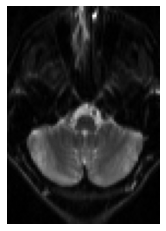

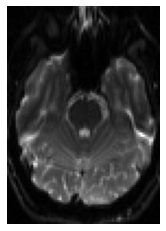

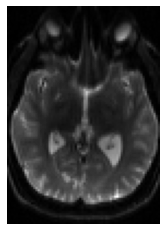

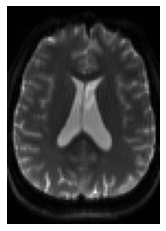

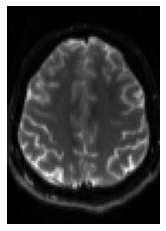

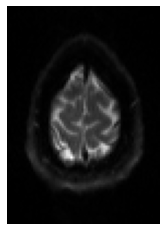

In [ ]:
for ii in range(6):
    plt.imshow(M0_mag[20:120,30:100,ii,0,0],cmap = 'gray')
    plt.axis('off')
    plt.show()